# Churn 데이터를 바탕으로 생성모델
<br>

## **수정사항**

1. **Evaluate**
    * KS보다 더 엄밀하게 거리를 재는 Wasseretein Distance가 가장 작은 모델을 저장하는 방식 

<br> 

2. **Loss 수정  (엄밀X)**
    * 기존 GAN Loss에 추가적으로 통계량값 Loss를 추가함
        * Wasserstein Loss
        * Numerical : 
            * moment , cosine similarity , 
        * Categorcial :
            * Ratio , KL Loss

<br>

3. **Continuous : sqnl(-1,1) / Categorical : Softmax**로 생성

<br>

4. **Tensorboard 시각화**

<BR>
    
---

> 학습은 데이터에 따라서 많이 불안정하므로, 많은 시도가 필요함.

## Library 와 Data Load

In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets , sys
from sklearn.preprocessing import MinMaxScaler
from Functions import *
from IPython.display import clear_output
from sklearn import preprocessing 
from scipy.stats import wasserstein_distance as was_dist
churn = pd.read_csv("Churn.csv")

In [34]:
churn.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [35]:
churn.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

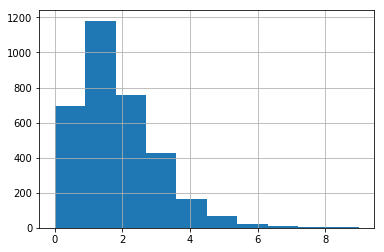

In [36]:
churn["customer service calls"].hist()

In [37]:
churn.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [38]:
Real = churn[["state", "international plan" , 'total day charge' ,
              'total eve charge' ,  'total intl calls','customer service calls' , 
              'total day calls' , 'churn' , 'area code' , 'account length' ,  'total intl charge' , 
              'voice mail plan' , 'total day minutes' ,'total night charge'
             ]]

In [39]:
Real.dtypes

state                      object
international plan         object
total day charge          float64
total eve charge          float64
total intl calls            int64
customer service calls      int64
total day calls             int64
churn                        bool
area code                   int64
account length              int64
total intl charge         float64
voice mail plan            object
total day minutes         float64
total night charge        float64
dtype: object

## PostProcessing


* Numeric
    * Inverse Transform을 진행해서 원래 분포의 범위로 변환시켜주기
    * **integer**
        * count variable 같은 경우 round로 정수형으로 처리해주기?
    * **numeric**
        * 그대로 사용해도 가능 할 듯
* Categorical
    * softmax로 나오므로 argmax 처리하고, 분포를 보여줄때는 수치형으로 보여주고 사용할 때는 변환하는 방식
    * 일단 그림을 그릴 때는 그대로 사용하면 될 듯

In [40]:
Real.head()

,state,international plan,total day charge,total eve charge,total intl calls,customer service calls,total day calls,churn,area code,account length,total intl charge,voice mail plan,total day minutes,total night charge
0,KS,no,45.07,16.78,3,1,110,False,415,128,2.70,yes,265.1,11.01
1,OH,no,27.47,16.62,3,1,123,False,415,107,3.70,yes,161.6,11.45
2,NJ,no,41.38,10.30,5,0,114,False,415,137,3.29,no,243.4,7.32
3,OH,yes,50.90,5.26,7,2,71,False,408,84,1.78,no,299.4,8.86
4,OK,yes,28.34,12.61,3,3,113,False,415,75,2.73,no,166.7,8.41


In [41]:
float_name = Real.select_dtypes(include= ["float"]).columns.tolist()
float_name

['total day charge',
 'total eve charge',
 'total intl charge',
 'total day minutes',
 'total night charge']

In [42]:
Int_name = Real.select_dtypes(include= ["integer"]).columns.tolist()
object_name = Real.select_dtypes(exclude= ["number"]).columns.tolist()
numeric_name = Real.select_dtypes(include= ["number"]).columns.tolist()
object_name.extend(["area code"])
numeric_name.remove("area code")
Int_name = list(set(Int_name) - set(object_name))
print("NUMERIC : " ,numeric_name)
print("OBJECT : ", object_name)
print("Int : ",Int_name)

NUMERIC :  ['total day charge', 'total eve charge', 'total intl calls', 'customer service calls', 'total day calls', 'account length', 'total intl charge', 'total day minutes', 'total night charge']
OBJECT :  ['state', 'international plan', 'churn', 'voice mail plan', 'area code']
Int :  ['customer service calls', 'account length', 'total day calls', 'total intl calls']


In [43]:
Real = Real[numeric_name + object_name ]
Real[object_name] = Real[object_name].astype(str)

In [44]:
feature = Real.columns.tolist()

In [45]:
total_length = 0 
info = {}
for i in object_name :
    value = Real[i].nunique()
    info[i] = value
    total_length += value
    
total_length += len(numeric_name)
print(total_length)
print(info)

69
{'state': 51, 'international plan': 2, 'churn': 2, 'voice mail plan': 2, 'area code': 3}


In [46]:
info.get("state")

51

In [47]:
data = Real.values
def sample_data(n= len(data) , data = None) : 
    output = data[list(np.random.choice(len(data) , n))]
    return output

In [48]:
input_dim = np.shape(data)[1] 
latet_dim = 20
BATCH_SIZE = 100

def generator(Z , batch_size , hsize=[ 50, 80 , 100],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0]  , activation = None )
        h2 = tf.layers.dense(h1,hsize[1]-15,activation=parametric_relu , use_bias=True)
        h2 = tf.layers.dense(h2,hsize[1]-15,activation=None) 
        h2 = tf.layers.dense(h2,hsize[1],activation= parametric_relu , use_bias=True )
        h2 = tf.layers.dense(h1,hsize[1],activation=None) 
        h2 = tf.layers.dense(h2, hsize[2] , activation = tf.nn.leaky_relu , use_bias=True )  
        out = tf.layers.dense(h2,  total_length , activation = None , use_bias= True )
        num = tf.slice(out , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        first = tf_sqnl(num)
        NUM = 0
        for i in object_name :
            cat = tf.slice(out , [0,len(numeric_name) + NUM ] , [batch_size , info.get(i)] ) # 
            Species = tf.nn.softmax(cat)
            NUM += info.get(i)
            first = tf.concat([first , Species], axis = 1 , name = i[0] )
    return first


def discriminator(X,hsize=[70, 40],reuse=True):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu , name = "D1")
        #h1 = minibatch(h1 , name = "D1")
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu , name = "D2" )
        h2 = minibatch(h2 , num_kernels = 5 ,  bs = BATCH_SIZE ,name = "Minibatch_Discrimination")
        h3 = tf.layers.dense(h2,10 ,activation=tf.nn.leaky_relu , name = "D3" )
        #h3 = minibatch(h3 , name = "D3")
        out = tf.layers.dense(h3,1) # activation=None OUTPUT
    return out, h3

def sample_Z(m , n ):
    return np.random.uniform(-1., 1., size=[m , n])


In [49]:
input_dim

14

In [50]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,[None, total_length  ], name= "X")
Z = tf.placeholder(tf.float32,[None,latet_dim ] , name = "Z")
batch_size = tf.placeholder(tf.int64, name="Batchsize")

In [51]:
EPOCHS = 10000
BATCH_SIZE = 100
data_len = np.shape(data)[0]
batch_iter = int(data_len / BATCH_SIZE)
dataset = tf.data.Dataset.from_tensor_slices((X, Z)).batch(batch_size , drop_remainder=True ).repeat().shuffle(1000)
iter = dataset.make_initializable_iterator()
x , z = iter.get_next()

print(batch_iter)

33


In [52]:
G_sample = generator(z , batch_size)
r_logits, r_rep = discriminator(x,reuse=False)
f_logits, g_rep = discriminator(G_sample,reuse=True)

In [53]:
def moment(x = None , nth = 3) :
    """Column 별 3차 모멘트 계산"""
    standard = tf.div(x - tf.reduce_mean(x, axis = 0) , tf.math.reduce_std(x , axis = 0))
    pow_3 = tf.pow(standard ,nth )
    three_moment = tf.reduce_mean(pow_3 , axis = 0)
    return three_moment

In [54]:
e = tf.random_uniform([BATCH_SIZE , 1] , 0 , 1)
x_hat =  e * x + (1-e) * G_sample
grad  = tf.gradients( discriminator(x_hat, reuse=True ), x_hat)[0]
slopes = tf.sqrt(1e-8 + tf.reduce_sum(tf.square(grad), axis=[1]))
gradient_penalty = 5 * tf.reduce_mean((slopes - 1.) ** 2)

fake_logit = (f_logits - tf.reduce_mean(r_logits))
real_logit = (r_logits - tf.reduce_mean(f_logits))
real_logit = tf.sigmoid( real_logit )
fake_logit = tf.sigmoid( fake_logit )

with tf.variable_scope("Discriminator_Loss") :        
    disc_loss = - tf.reduce_mean( log(real_logit)) - tf.reduce_mean( log(1-fake_logit ))
    disc_loss += gradient_penalty

## Numeric 변수에 대한 Correlation Loss 추가
### 이유는 상관관계가 유사하게 나와야 하기 때문에 규제를 주는 역할을 기대할 수 있다!
### Generator Loss에 넣어서 Generator에서만 Weight 조절할수 있게! 
with tf.variable_scope("Generator_Loss"):
    with tf.variable_scope("Original_Loss"):
        gen_loss = - tf.reduce_mean( log( fake_logit )) - tf.reduce_mean( log(1- real_logit ))
        #gen_loss  = - tf.reduce_mean(f_logits)
        # -tf.reduce_sum(tf.reduce_mean(f_logits , axis = 0 ))
    with tf.variable_scope("Corr_Loss"):
        num_G = tf.slice(G_sample , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        num_R = tf.slice(x , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        matrix = tf_cov(num_G) - tf_cov(num_R)
        Upper_triangular = tf.matrix_band_part(matrix, 0, -1)
        corr_loss = tf.reduce_sum(tf.square( Upper_triangular ))        
    tf.summary.scalar("Corr_loss", corr_loss)
    gen_loss += 2 * corr_loss
    with tf.variable_scope("wasserstein_Loss"):
        num_G = tf.slice(G_sample , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        cat_G = tf.slice(G_sample , [0, len(numeric_name)] , [batch_size,  -1 ] )  # 
        Round_G = Differ_Round(cat_G)
        Processing_G = tf.concat([num_G , Round_G] , axis = 1 )
        wasserstein = Wasserstein(Processing_G  , x , BATCH_SIZE)
        loss = wasserstein.dist(C=0.1, nsteps=10)
    tf.summary.scalar("wasserstein_loss", loss)
    gen_loss += loss
    with tf.variable_scope("Stat"):
        Gcol_mean , Gcol_var = tf.nn.moments(G_sample , axes = [0])
        Xcol_mean , Xcol_var = tf.nn.moments(x , axes = [0])
        G_mean , G_var = tf.nn.moments(G_sample , axes = [0,1])
        X_mean , X_var = tf.nn.moments(x , axes = [0,1])
        Colstat = tf.reduce_mean(tf.square(Gcol_mean - Xcol_mean)) \
        + tf.reduce_mean(tf.square( tf.sqrt(Gcol_var) - tf.sqrt(Xcol_var)))
        Totalstat = tf.reduce_mean(tf.square(G_mean - X_mean)) \
        + tf.reduce_mean(tf.square( tf.sqrt(G_var) - tf.sqrt(X_var)))
        ## 추가 빈도 비율이 유사하게 되지 않을까!?
    with tf.variable_scope("Categorical_Ratio"):
        cat_G = tf.slice(G_sample , [0, len(numeric_name)] , [batch_size,  -1 ] )  # 
        cat_R = tf.slice(x , [0,  len(numeric_name)] , [batch_size,  -1] )  # 
        Round_G = tf.reduce_sum(Differ_Round(cat_G) , axis = 0 )
        Round_R = tf.reduce_sum(Differ_Round(cat_R) , axis = 0 )
        D = tf.shape(cat_R)[1]
        q_sigma = tf.ones(D) * 2.0
        p_sigma = tf.ones(D) * 2.0
        KL_LOSS = tf.reduce_sum(tf.distributions.kl_divergence(
            tf.distributions.Normal(loc=Round_G, scale=q_sigma),
            tf.distributions.Normal(loc=Round_R, scale=p_sigma)), axis=-1)
        
        """
        제한은 주지만, 너무 Loss가 크게 의존하지는 않게,
        """
        Cat_Ratio = tf.reduce_mean( tf.square(Round_G - Round_R) ) * 0.5
        normalize_a = tf.nn.l2_normalize(Round_G,0)        
        normalize_b = tf.nn.l2_normalize(Round_R,0)
        cos_similarity=tf.reduce_sum(tf.multiply(normalize_a,normalize_b))
        Similarity_Loss = 1 * cos_similarity
    tf.summary.scalar("Categorical_Ratio_loss", Cat_Ratio)
    tf.summary.scalar("Colstat_loss", Colstat)
    tf.summary.scalar("Totalstat_loss", Totalstat)
    tf.summary.scalar("Similarity_loss", Similarity_Loss)
    tf.summary.scalar("Categorical_KL_loss", KL_LOSS)
    gen_loss +=  Totalstat + Cat_Ratio + Similarity_Loss + KL_LOSS
    with tf.variable_scope("Moment"):
        num_G = tf.slice(G_sample , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        num_R = tf.slice(x , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        Diff_3 = moment(num_G,3) - moment(num_R,3)
        three_moment_diff = tf.reduce_sum(tf.square(Diff_3))
        Diff_4 = moment(num_G,4) - moment(num_R,4)
        four_moment_diff = tf.reduce_sum(tf.square(Diff_4))
    tf.summary.scalar("3th_moment", three_moment_diff)
    tf.summary.scalar("4th_moment", four_moment_diff)
    gen_loss += three_moment_diff + four_moment_diff

tf.summary.scalar("Dloss", disc_loss)
tf.summary.scalar("Gloss", gen_loss)

t_vars = tf.trainable_variables()

for var in t_vars :
    tf.summary.histogram(var.op.name, var)

global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")
lr = 0.001
learning_rate = tf.train.exponential_decay(lr, global_step, decay_steps=100, decay_rate=0.998, staircase=True , )

tf.summary.scalar("learning_rate", learning_rate)
with tf.variable_scope("Optimizer"):
    gen_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(gen_loss,var_list = gen_vars) # G Train step
    disc_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(disc_loss,var_list = disc_vars) # D Train step
    

In [55]:
tensorboard()

In [56]:
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
merged_summary = tf.summary.merge_all()
sess = tf.Session(config= config)
saver = tf.train.Saver()

naming = 'Gan_Chrun_Result'
suumary_dir = "/home/advice/Python/SR/board/" + naming
img_dir = "./" + naming

try :
    if tf.gfile.Exists(suumary_dir):
        tf.gfile.DeleteRecursively(suumary_dir)
        tf.gfile.MakeDirs(suumary_dir)
        tf.gfile.DeleteRecursively(img_dir)
        tf.gfile.MakeDirs(img_dir)
except Exception as e :
    tf.gfile.MakeDirs(img_dir)
tf.gfile.MakeDirs(img_dir)
    
writer = tf.summary.FileWriter(suumary_dir)
writer.add_graph(sess.graph )
tf.global_variables_initializer().run(session=sess)

In [57]:
load_model = False
if load_model == True :
    print("학습된 모델 사용하기")
    save_file = "./savemodel/gan.meta"
    saver = tf.train.import_meta_graph(save_file)
    saver.restore(sess, tf.train.latest_checkpoint('./savemodel/'))
else :
    print("처음부터 학습시키기")

처음부터 학습시키기


## 변환 후처리 예시

label encoder로 문자를 숫자로 변환 -> 생성 후에 다시 문자로 변환

### 변환해주기 (문자 -> 숫자)

In [110]:
example = data.copy()
label_ecoding = {}
for i in range(len(numeric_name) , np.shape(data)[1]) :
    print(i , feature[i] )
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(example[:,i])
    label_ecoding[feature[i]] = label_encoder
    encoding = label_encoder.transform(example[:,i])
    example[:,i] = encoding

9 state
10 international plan
11 churn
12 voice mail plan
13 area code


### 다시 변환해주기 (숫자 -> 문자)

In [111]:
for i in range(len(numeric_name) , np.shape(data)[1]) :
    print(i , feature[i])
    example[:,i] = label_ecoding[feature[i]].inverse_transform(example[:,i].tolist())

9 state
10 international plan
11 churn
12 voice mail plan
13 area code


In [113]:
example

array([[45.07, 16.78, 3, ..., 'False', 'yes', '415'],
       [27.47, 16.62, 3, ..., 'False', 'yes', '415'],
       [41.38, 10.3, 5, ..., 'False', 'no', '415'],
       ...,
       [30.74, 24.55, 6, ..., 'False', 'no', '510'],
       [36.35, 13.57, 10, ..., 'False', 'no', '510'],
       [39.85, 22.6, 4, ..., 'False', 'yes', '415']], dtype=object)

In [126]:
original = data.copy()
transform = original.copy()

## Category를 숫자로 변환

`label_ecoding` 객체에 labelEncoder 정보 저장해놓음.

In [127]:
label_encoder = preprocessing.LabelEncoder()
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
##
TOTAL = data[:,:len(numeric_name)]
onehot_bin = []
label_ecoding = {}
for i in range(len(numeric_name) , np.shape(data)[1]) :
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(example[:,i])
    label_ecoding[feature[i]] = label_encoder
    encoding = label_encoder.transform(data[:,i])
    onehot_encoder.fit(np.array(encoding).reshape(-1,1))
    cat = onehot_encoder.transform(np.array(encoding).reshape(-1,1))
    onehot_bin.append(TOTAL.shape[1])
    TOTAL = np.concatenate((TOTAL , cat) , axis = 1 )
    transform[:,i] = label_encoder.transform(transform[:,i])

data= TOTAL
del TOTAL
onehot_bin += [data.shape[1]]
print(onehot_bin)

[9, 60, 62, 64, 66, 69]


/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you 

In [128]:
transform

array([[45.07, 16.78, 3, ..., 0, 1, 1],
       [27.47, 16.62, 3, ..., 0, 1, 1],
       [41.38, 10.3, 5, ..., 0, 0, 1],
       ...,
       [30.74, 24.55, 6, ..., 0, 0, 2],
       [36.35, 13.57, 10, ..., 0, 0, 2],
       [39.85, 22.6, 4, ..., 0, 1, 1]], dtype=object)

In [129]:
x_plot = sample_data(n= 1000 , data = transform ).astype(float) # len(data)
x_plot.shape

(1000, 14)

In [130]:
nd_steps = 2
ng_steps = 10
save_model = True
scaler = MinMaxScaler(feature_range=(-1. ,1.))
data[:,:len(numeric_name)] = scaler.fit_transform(data[:,:len(numeric_name)])

In [131]:
data.shape

(3333, 69)

In [132]:
x_plot.shape

(1000, 14)

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


customer service calls
gene -----------
[473 205 142  98  43  27   7   4   1]
true -----------
[224 328 244 132  50  15   6   1]
-----------------
account length
gene -----------
[15  6  2  1  2  2  0  1  0  1  2  1  1  3  0  0  2  1  2  0  1  0  0  1
  1  2  1  2  1  1  2  3  1  1  2  5  2  1  3  0  5  3  0  2  0  2  4  5
  0  2  2  2  7  3  5  6  4  4  8  8  9  5  4  4  7  8  2  7  7  7 13  7
 13 16  8 10 11  4  4 15  6 11 11 17 11  7  5 11 10 13 15  6 13  5 16  9
 12 12  7 12  7 10  8  4 11  5 13  9 10  8  8  6  8  8  7  8  6  9  6  7
  6  6  5  3  3  8  5  8 12  8  7  4 10 10  4  7  3  6  9  8  4  8  2  5
  4  4  1  5  4  3  6  3  4  4  5  8  4  0  3  2  3  3  7  8  5  2  0  6
  3  5  3  1  0  4  4  6  1  0  1  2  2  2  1  5  3  2  5  3  4  1  2  0
  1  3  0  0  0  0  2  2  0  1  0  1  0  0  2  1  0  0  2  0  1  1  1  1
  0  0  0  0  1  0  0  0  0  1  1  0  0  0  0  0  1]
true -----------
[ 0  3  0  1  0  0  0  0  0  0  2  1  1  2  0  0  1  1  0  1  0  4  1  0
  3  2  0  2  5  1  4

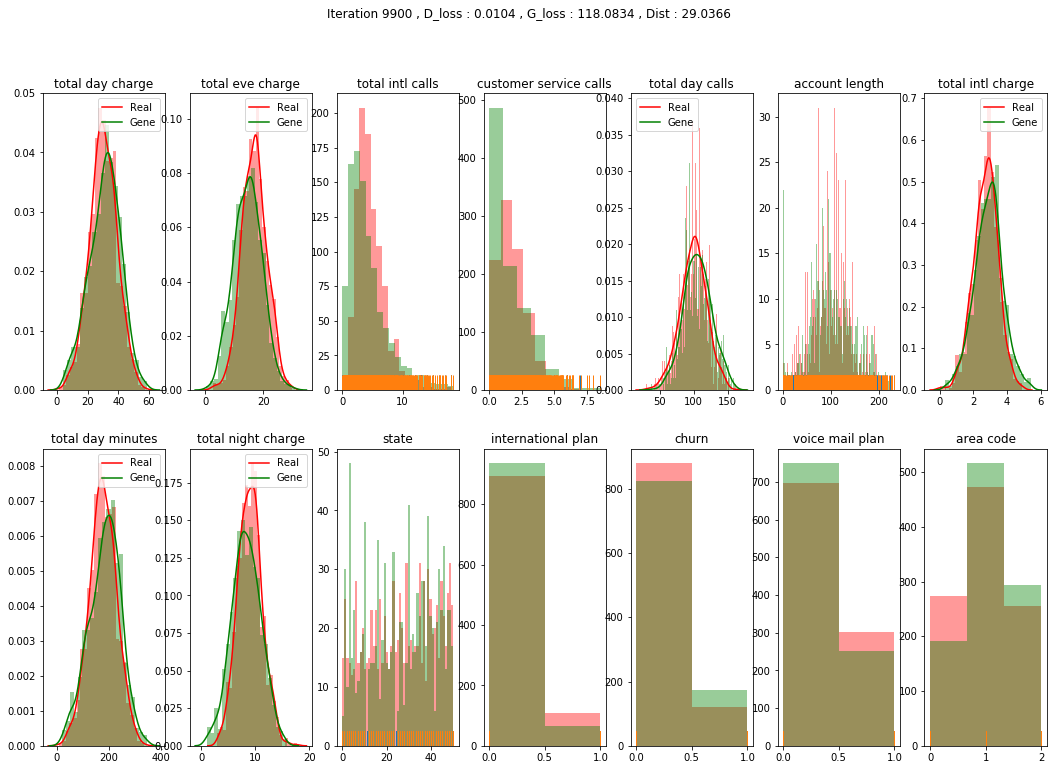

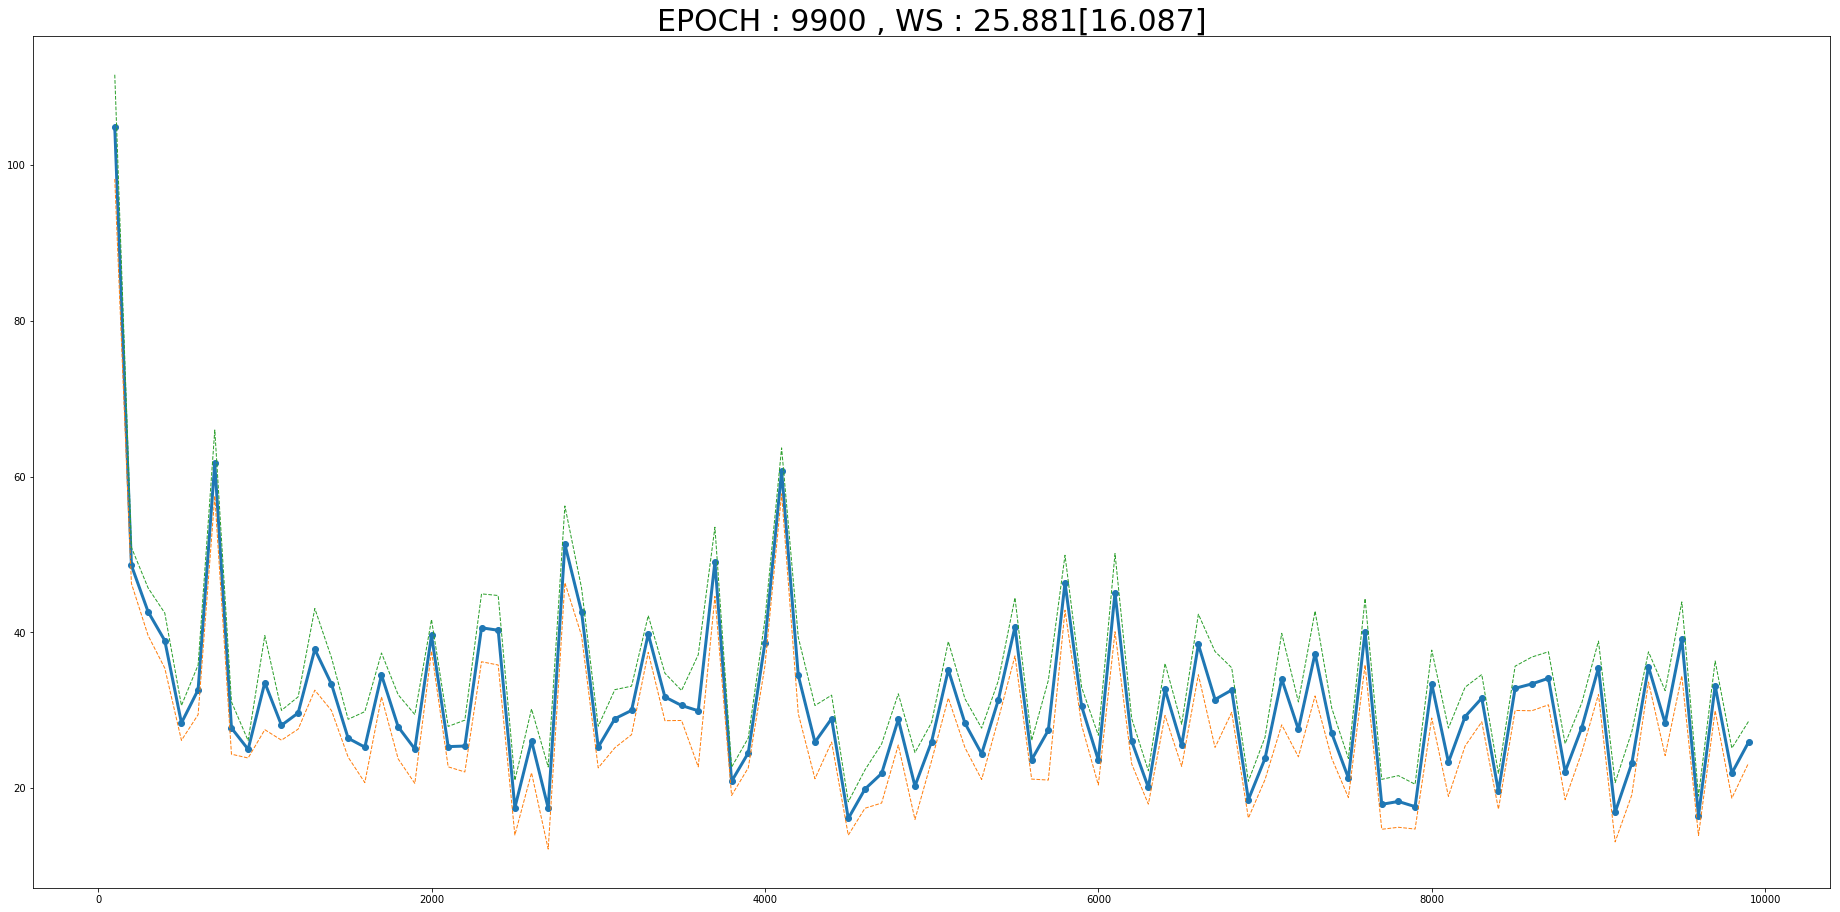

In [133]:
imgs = []
Total_ws = pd.DataFrame({"iter":[0] , "ws" :[0], "wstd" : [0]})
for i in range(EPOCHS) : 
    z_batch = sample_Z(data_len , latet_dim )
    sess.run(iter.initializer, feed_dict={ X : data , 
                                          batch_size: BATCH_SIZE , 
                                          Z : z_batch  ,
                                         })
    for _ in range(nd_steps):
        _, dloss  = sess.run([disc_step, disc_loss] , feed_dict={global_step : i ,
                                                                 batch_size : BATCH_SIZE
                                                                })

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={global_step : i , 
                                                             batch_size : BATCH_SIZE
                                                            })

    if i% 100 == 0 :
        try :
            _ , _ , _ , _ , summary_str = sess.run([disc_step , gen_step , disc_loss , gen_loss , merged_summary] , 
                                                   feed_dict = {global_step : i ,
                                                                batch_size : BATCH_SIZE
                                                               })
            writer.add_summary(summary_str , global_step = i)
        except Exception as e :
            pass 
        ## Model Save
        if save_model == True :
            saver.save(sess, './savemodel/gan')
        clear_output(wait= True)
        generate_n = 1000
        z_batch = sample_Z(generate_n  , latet_dim )
        g_plot = sess.run(G_sample , feed_dict = {z : z_batch , batch_size : generate_n})
        g_plot[:,:len(numeric_name)] = scaler.inverse_transform(g_plot[:,:len(numeric_name)])
        g_numeric = g_plot[:,:len(numeric_name)]
        for idx , _ in enumerate(onehot_bin[:-1]) :
            cat = np.argmax(g_plot[:, onehot_bin[idx] : onehot_bin[idx+1] ], 1 )
            g_numeric = np.concatenate((g_numeric ,cat[:,np.newaxis] ) , axis = 1 )
        g_plot = g_numeric
        del g_numeric
        fig, ax = plt.subplots(2,7, figsize=(18, 12))
        axx = ax.flatten()
        num = 0
        total_dist = 0 
        for n , name in enumerate(feature) :
            try :
                total_dist += was_dist(x_plot[:,n], g_plot[:,n])
            except Exception as e :
                pass

            if name in ['international plan', 'churn', 'area code' , "state" , "account length" , 'customer service calls' ]  :
                print(name)
                print("gene -----------")
                print(np.bincount( np.array(g_plot[:,n]).astype(int) ) )
                print("true -----------")
                print(np.bincount( np.array(x_plot[:,n]).astype(int) ) )
                print("-----------------")
            ## integer 
            if name in ['international plan', 'churn', 'area code', 
                        'voice mail plan' , "account length" , 'customer service calls' ,  "state" , 'total intl calls']  :
                binsize = len(np.unique(x_plot[:,n].astype(float) ))
                sns.distplot(x_plot[:,n].astype(float) , kde = False ,  
                             hist_kws ={"color":"r", "label" : "Real"} ,  
                             bins = binsize ,
                             rug = True , ax = axx[num])
                sns.distplot(g_plot[:,n],  kde = False ,  
                             hist_kws ={"color":"g" , "label" : "Gene"} ,
                             bins = binsize , 
                             rug = True   , ax = axx[num])
            else :
                if name in Int_name  : 
                    Real  = x_plot[:,n].astype(float).round(0)
                    Fake  = g_plot[:,n].round(0)
                    binsize= len(np.unique(Real))
                    sns.distplot(Real  , kde_kws ={"color": "r", "label" : "Real"} , bins = binsize ,
                                 hist_kws ={"color":"r"}, ax = axx[num])
                    sns.distplot(Fake , kde_kws ={"color": "g", "label" : "Gene"} , bins = binsize ,
                                 hist_kws ={"color":"g"}, ax = axx[num])
                else :
                    Real  = x_plot[:,n].astype(float)
                    Fake  = g_plot[:,n]
                    sns.distplot(Real  , kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = axx[num])
                    sns.distplot(Fake , kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = axx[num])
            axx[num].set_title("{}".format(name))
            num +=1
        plt.suptitle('Iteration %d , D_loss : %.4f , G_loss : %.4f , Dist : %.4f'%(i,dloss,gloss, total_dist) )
        plt.savefig( img_dir + '/iteration_%d.png'%i)
        imgs.append( img_dir + '/iteration_%d.png'%i)
        plt.show()
        total_dist = []
        for _ in range(10) :
            sampling = sample_data(n= generate_n , data = transform).astype(float) # len(data)
            dist = 0
            for col in range(len(feature)) :
                try :
                    dist += was_dist(sampling[:,col], g_plot[:,col])
                except Exception as e :
                    ## Penalty
                    dist += 100
                    pass
            total_dist.append(dist)
        total_std = np.std(total_dist)
        total_dist = np.mean(total_dist)
        iter_ws = pd.DataFrame({"iter":[i] , "ws" :[total_dist] , "wstd" : [total_std]})
        Total_ws    = Total_ws.append(iter_ws)
        fig , ax = plt.subplots(figsize = (26,13))
        fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.04 , right = 0.99)
        Total_ws = Total_ws[Total_ws.iter > 0 ]
        ax.plot(Total_ws["iter"] , Total_ws["ws"] , linestyle ="-" , marker ="." , linewidth = 3, markersize = 12)
        ax.plot(Total_ws["iter"] , Total_ws["ws"]-1.96*Total_ws["wstd"] , linestyle ="dashed"  , linewidth = 1)
        ax.plot(Total_ws["iter"] , Total_ws["ws"]+1.96*Total_ws["wstd"] , linestyle ="dashed"  , linewidth = 1)
        ax.set_title("EPOCH : {} , WS : {:.3f}[{:.3f}]".format(i , total_dist , Total_ws.ws.min()) , fontsize = 30)
        plt.savefig('./{}.png'.format(naming))
        plt.show()

In [134]:
import os
img2gif = 'convert -delay 30 -loop 0 %s {}/simulation.gif'.format(img_dir)
os.system(img2gif % ' '.join(imgs))

0

## Data Generate

1. **Origianl Scale Inverse Transform**
2. **Label Encoder Inverse Transform**

In [138]:
generate_n = 5000
z_batch = sample_Z(generate_n  , latet_dim )
g_plot = sess.run(G_sample , feed_dict = {z : z_batch , batch_size : generate_n})
g_plot[:,:len(numeric_name)] = scaler.inverse_transform(g_plot[:,:len(numeric_name)])
g_numeric = g_plot[:,:len(numeric_name)]
for idx , _ in enumerate(onehot_bin[:-1]) :
    cat = np.argmax(g_plot[:, onehot_bin[idx] : onehot_bin[idx+1] ], 1 )
    g_numeric = np.concatenate((g_numeric ,cat[:,np.newaxis] ) , axis = 1 )
    
g_numeric = g_numeric.astype(object)

In [140]:
for i in range(len(numeric_name) , np.shape(g_numeric)[1]) :
    print(i , feature[i])
    g_numeric[:,i] = label_ecoding[feature[i]].inverse_transform(g_numeric[:,i].astype(int).tolist())

9 state
10 international plan
11 churn
12 voice mail plan
13 area code


In [145]:
Gen = pd.DataFrame(g_numeric , columns= feature)
Gen.shape

(5000, 14)

In [144]:
Gen.head(10)

,total day charge,total eve charge,total intl calls,customer service calls,total day calls,account length,total intl charge,total day minutes,total night charge,state,international plan,churn,voice mail plan,area code
0,28.2228,11.1796,3.67826,1.60966,146.822,98.7526,2.68033,175.374,8.92256,NJ,yes,False,yes,408
1,55.3807,16.3459,1.65406,1.4732,103.919,147.748,1.88057,317.332,5.9924,WY,no,True,yes,415
2,42.7873,14.7435,2.05231,2.93611,109.383,91.6658,2.97336,240.828,7.97727,NM,no,False,no,415
3,36.5206,8.12874,4.03958,0.794009,117.01,118.192,1.96153,209.338,4.99279,TN,no,False,no,408
4,42.5026,27.2303,4.69917,2.19604,92.9399,57.808,2.33245,235.492,5.84324,TX,no,False,no,415
5,25.4927,25.7585,3.19303,2.42238,114.94,86.6332,2.64431,139.275,6.98575,MA,no,False,yes,510
6,32.7657,19.68,2.4946,2.62469,125.93,89.2891,3.29683,194.673,8.34564,IA,no,False,yes,415
7,45.87,9.8404,3.55804,5.31113,118.071,71.0026,3.3346,265.536,9.55019,CT,no,False,yes,408
8,32.3852,19.3452,3.72636,1.69265,122.993,95.0254,3.28649,191.549,6.44052,DC,no,False,no,408
9,54.5249,16.2518,2.39283,1.8627,92.9049,123.441,1.89921,314.862,11.7964,RI,no,True,no,415
